# Purpose
- One model, 3 datasets
- Compare Lap, AIC, BIC and MCMC
- Explore details of Lap
- Figures I want:
    - Lap and MCMC overlaid on the likelihood function
    - Table comparing the 3 datasets for all metrics

In [6]:
import sys
sys.path.insert(1, "..")
import pprint
import gpytorch
import torch
import numpy as np
import metrics
import copy
import configparser
from experiment_functions import Experiment
from GaussianProcess import ExactGPModel
from globalParams import options, hyperparameter_limits
import gpytorch
from helpFunctions import get_string_representation_of_kernel as gsr
from helpFunctions import clean_kernel_expression
from helpFunctions import get_kernels_in_kernel_expression, get_full_kernels_in_kernel_expression
from helpFunctions import amount_of_base_kernels
from itertools import product
import json
from kernelSearch import *
from matplotlib import pyplot as plt
from metrics import *
from multiprocessing import Pool
import numpy as np
import os
import pdb
import pickle
import random
import tikzplotlib
import time
import torch
from tqdm import tqdm
from scipy.stats import multivariate_normal
import matplotlib as mpl
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# To run STAN in a Jupyter notebook
import nest_asyncio
nest_asyncio.apply()



torch.manual_seed(42)


In [7]:
torch.set_default_dtype(torch.float64)

# Helper functions

In [8]:
def random_reinit(model):
    for i, (param, limit) in enumerate(zip(model.parameters(), [{"Noise": hyperparameter_limits["Noise"]},*[hyperparameter_limits[kernel] for kernel in get_full_kernels_in_kernel_expression(model.covar_module)]])):
        covar_text = gsr(model.covar_module)
        param_name = list(limit.keys())[0]
        new_param_value = torch.randn_like(param) * (limit[param_name][1] - limit[param_name][0]) + limit[param_name][0]
        param.data = new_param_value



# Define the training loop
def optimize_hyperparameters2(model, likelihood, **kwargs):
    """
    find optimal hyperparameters either by BO or by starting from random initial values multiple times, using an optimizer every time
    and then returning the best result
    """
    log_param_path = kwargs.get("log_param_path", False)
    log_likelihood = kwargs.get("log_likelihood", False)
    random_restarts = kwargs.get("random_restarts", options["training"]["restarts"]+1)
    line_search = kwargs.get("line_search", False)
    BFGS_iter = kwargs.get("BFGS_iter", 50)
    train_iterations = kwargs.get("train_iterations", 0)
    train_x = kwargs.get("X", model.train_inputs)
    train_y = kwargs.get("Y", model.train_targets)
    with_BFGS = kwargs.get("with_BFGS", False)
    history_size = kwargs.get("history_size", 100)
    MAP = kwargs.get("MAP", True)
    prior = kwargs.get("prior", False)
    granso = kwargs.get("granso", True)

    # Set up the likelihood and model
    #likelihood = gpytorch.likelihoods.GaussianLikelihood()
    #model = GPModel(train_x, train_y, likelihood)

    # Define the negative log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Set up the PyGRANSO optimizer
    opts = pygransoStruct()
    opts.torch_device = torch.device('cpu')
    nvar = getNvarTorch(model.parameters())
    opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
    opts.opt_tol = float(1e-10)
    opts.limited_mem_size = int(100)
    #opts.double_precision=False
    opts.globalAD = True
    opts.quadprog_info_msg = False
    opts.print_level = int(0)
    opts.halt_on_linesearch_bracket = False

    # Define the objective function
    def objective_function(model):
        output = model(train_x)
        loss = -mll(output, train_y)
        log_p = log_normalized_prior(model)
        loss -= log_p
        return [loss, None, None]

    best_model_state_dict = model.state_dict()
    best_likelihood_state_dict = likelihood.state_dict()

    random_restarts = int(5)
    best_f = np.inf
    for restart in range(random_restarts):
        print(f"pre training parameters: {list(model.named_parameters())}")
        # Train the model using PyGRANSO
        soln = pygranso(var_spec=model, combined_fn=objective_function, user_opts=opts)
        if soln.final.f < best_f:
            best_f = soln.final.f
            best_model_state_dict = model.state_dict()
            best_likelihood_state_dict = likelihood.state_dict()
        print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f} (smaller=better)")
        random_reinit(model)

    model.load_state_dict(best_model_state_dict)
    likelihood.load_state_dict(best_likelihood_state_dict)

    loss = -mll(model(train_x), train_y)
    log_p = log_normalized_prior(model)
    loss -= log_p

    print(f"post training (best): {list(model.named_parameters())} w. loss: {soln.best.f}")
    print(f"post training (final): {list(model.named_parameters())} w. loss: {soln.final.f}")
    
    print(torch.autograd.grad(loss, [p for p in model.parameters()], retain_graph=True, create_graph=True, allow_unused=True))
    # Return the trained model
    return loss, model, likelihood


def get_std_points(mu, K):
    x, y = np.mgrid[float(-3):float(3):float(.1), float(-3):float(3):float(.1)]
    rv = multivariate_normal(mu, K)
    L = np.linalg.cholesky(K)

    data = np.dstack((x, y))
    z = rv.pdf(data)

    # Drawing the unit circle
    # x^2 + y^2 = 1
    precision = int(50)
    unit_x = torch.cat([torch.linspace(float(-1), float(1), precision), torch.linspace(float(-1), float(1), precision)])
    unit_y = torch.cat([torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2)), -torch.sqrt(float(1) - torch.linspace(float(-1), float(1), precision)**float(2))])

    new_unit_x = list()
    new_unit_y = list()

    for tx, ty in zip(unit_x, unit_y):
        res = np.array([tx, ty]) @ L
        new_unit_x.append(mu[0] + float(2)*res[0])
        new_unit_y.append(mu[1] + float(2)*res[1])
    return new_unit_x, new_unit_y



# Temp adam

In [9]:
def train_gp_with_adam(model, likelihood, train_x, train_y, num_epochs=100, lr=0.01):
    MAP = True
    # Set the model and likelihood to training mode
    model.train()
    likelihood.train()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define the negative log likelihood loss
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(train_x)
        loss = -mll(output, train_y)
        params_list = [p for p in model.parameters()]
        env_grads_pre = torch.autograd.grad(loss, params_list, retain_graph=True, create_graph=True, allow_unused=True)
        if MAP:
            log_p = log_normalized_prior(model)
            loss -= log_p

        env_grads_post = torch.autograd.grad(loss, params_list, retain_graph=True, create_graph=True, allow_unused=True)
        print([post - pre for (post, pre) in zip(env_grads_post, env_grads_pre)])
        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Print the loss for every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Set the model and likelihood back to evaluation mode
    model.eval()
    likelihood.eval()


In [10]:
class DataGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(DataGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [11]:
# Globals
figure_path = "grad_figures"

# Data 

tensor([-1.2649, -0.6325,  0.0000,  0.6325,  1.2649])
tensor([ 0.0509, -0.2846,  0.1393,  0.3349, -0.1463])


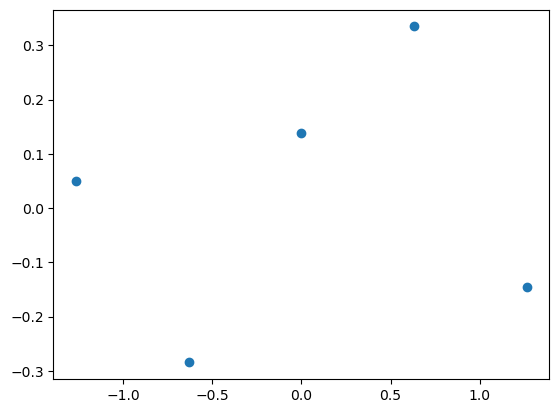

In [12]:
import math
torch.manual_seed(42)
END = 1
COUNT = 10
dataset_name = "noise_linear"
#dataset_name = "noise_sin"
#dataset_name = "noise_parabolic"
#dataset_name = "noise_SE"
dataset_name = "linear"
# linear
if "noise_linear" in dataset_name:
    train_x = torch.linspace(0, END, COUNT)
    train_y = torch.linspace(0, END, COUNT)
    train_y += torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1))
elif "linear" == dataset_name:
    train_x = torch.tensor([-5.0000, -2.5000,  0.0000,  2.5000,  5.0000])
    train_y = torch.tensor([-2.6991e+00, -1.3503e+00,  6.4322e-04,  1.3510e+00,  2.7006e+00])
    train_x = (train_x - torch.mean(train_x)
                    ) / torch.std(train_x)
    #train_y = (train_y - torch.mean(train_y)
    #                  ) / torch.std(train_y)
    noise_level = 0.1
    train_y = train_y + torch.randn(train_y.shape) * torch.sqrt(torch.tensor(noise_level))

    train_x = torch.tensor([-1.2649, -0.6325,  0.0000,  0.6325,  1.2649])
    train_y = torch.tensor([ 0.0509, -0.2846,  0.1393,  0.3349, -0.1463])
elif "sin" in dataset_name:
# sin
    train_x = torch.linspace(0, 1, COUNT)
    train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1)) 
##parabolic
elif "parabolic" in dataset_name:
    END = 2
    train_x = torch.linspace(-2, END, COUNT)
    train_y = train_x * train_x + 0.5 + torch.randn(train_x.size()) * torch.sqrt(torch.tensor(0.1)) 
elif "SE" in dataset_name:
    eval_START = -5
    eval_END = 5
    eval_COUNT = 5
    # training data for model initialization (e.g. 1 point with x=0, y=0) ; this makes initializing the model easier
    prior_x = torch.linspace(0, 1, 1)
    prior_y = prior_x
    # initialize likelihood and model
    data_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    data_model = DataGPModel(prior_x, prior_y, data_likelihood)
    observations_x = torch.linspace(eval_START, eval_END, eval_COUNT)
    # Get into evaluation (predictive posterior) mode
    data_model.eval()
    data_likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.prior_mode(True):
        observed_pred_prior = data_likelihood(data_model(observations_x))
        f_preds = data_model(observations_x)


    EXPERIMENT_REPITITIONS = 50
    for exp_num in tqdm(range(EXPERIMENT_REPITITIONS)):
        observations_y = f_preds.sample()           # samples from the model
        # To store performance of kernels on a test dataset (i.e. more samples)
        original_observations_x = copy.deepcopy(observations_x)
        observations_x = (observations_x - torch.mean(observations_x)
                        ) / torch.std(observations_x)
        noise_level = 0.4
        observations_y = observations_y + torch.randn(observations_y.shape) * torch.tensor(noise_level)
        #observations_y = (observations_y - torch.mean(observations_y)
        #                  ) / torch.std(observations_y)
        train_x = observations_x
        train_y = observations_y


plt.plot(train_x, train_y, "o")
print(train_x)
print(train_y)

plt.savefig(f"{figure_path}/data_{dataset_name}.png")
tikzplotlib.save(f"{figure_path}/data_{dataset_name}.tex")

# Model definition

In [13]:
model_name = "SE"
#model_name = "SE+SE"
#model_name = "LIN"
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, model_name="SE"):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if model_name == "SE":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel()
        elif model_name == "SE+SE":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel()
        elif model_name == "LIN":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.LinearKernel()
        else:
            raise ValueError("Invalid model_name")

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-30))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, model_name=model_name)

# Training

In [14]:
#train_gp_with_adam(model, likelihood, train_x, train_y, num_epochs=100, lr=0.01)

In [15]:
num_train_iter = 0
use_MAP = True 
use_LBFGS = False
LBFGS_iter = 50
# Train the MAP for 100 Iterations of ADAM and then 50 more of L-BFGS
loss, model, likelihood = optimize_hyperparameters2(model, likelihood,
                                                    X=train_x, 
                                                    Y=train_y
                                                   )
#loss,  model, likelihood = optimize_hyperparameters(model, likelihood, 
#                                                                 line_search=False, 
#                                                                 X=train_x, 
#                                                                 Y=train_y, 
#                                                                 train_iterations=0, 
#                                                                 #BFGS_iter=LBFGS_iter, 
#                                                                 #history_size=2*LBFGS_iter, 
#                                                                 #with_BFGS=use_LBFGS, 
#                                                                 #MAP=use_MAP, 
#                                                                 log_param_path=False, 
#                                                                 random_restarts=1, 
#                                                                 log_likelihood=False)


pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True))]
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-5.2774], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.4672]], requires_grad=True))] w. loss: 1.334572494381494 (smaller=better)
pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-0.0068], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[2.2070]], requires_grad=True))]
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-5.2774], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.4672]], requires_grad=True))] w. loss: 1.334572494381494 (smaller=better)
pre training parameters: [('likelihood.no

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1675740247391/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-5.2774], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.4672]], requires_grad=True))] w. loss: 1.334572494381494 (smaller=better)
pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0341], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.5354]], requires_grad=True))]
post training (final): [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-5.2774], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.4672]], requires_grad=True))] w. loss: 1.334572494381494 (smaller=better)
pre training parameters: [('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0828], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
tensor([[1.1102]], requires_grad=True))]
post training (final): [('likeliho

In [16]:
loss

tensor(1.3346, grad_fn=<SubBackward0>)

In [17]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-5.2774], requires_grad=True)),
 ('covar_module.raw_lengthscale',
  Parameter containing:
  tensor([[0.4672]], requires_grad=True))]

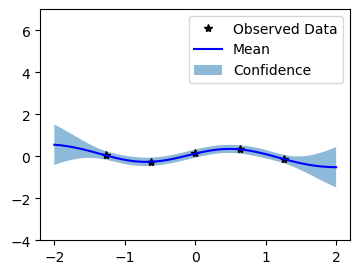

In [18]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-2, 2, 51)
    a = model(test_x)
    observed_pred = likelihood(a)
    
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-4, 7])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_posterior.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_posterior.tex")

# Laplace

In [19]:
#print(f"L-BFGS iterations: {len(training_log['log_likelihood']) - num_train_iter}")
model.train()
likelihood.train()
lap_approx_S, lap_log_S = metrics.calculate_laplace(model, -loss*len(*model.train_inputs), param_punish_term=0.0)
lap_approx_AIC, lap_log_AIC = metrics.calculate_laplace(model, -loss*len(*model.train_inputs), param_punish_term=-1.0)
lap_approx_BIC, lap_log_BIC = metrics.calculate_laplace(model, -loss*len(*model.train_inputs), param_punish_term="BIC")
print(lap_approx_S)
print(lap_log_S)
print(lap_approx_AIC)
print(lap_log_AIC)
print(lap_approx_BIC)
print(lap_log_BIC)

# Draw the distribution defined by the mean (found parametrization) and covariance matrix (Hessian)
# (4.133) in Bishop, 2006: f(z) ~ f(z_0)exp(-0.5 (z-z_0)^T H (z-z_0)) with z the parameters, and H the Hessian
# We just leave out the f(z_0)

#scaling_factor = lap_log["neg MLL"]
#mu = [p.item() for p in list(model.parameters())]
##mu = [training_log["log_param_path"][param_keys[0]][-1], training_log["log_param_path"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K.inverse()[:2, :2])
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

trained_mu = [p.item() for p in list(model.parameters())]

tensor(-6.7582, dtype=torch.float64, grad_fn=<AddBackward0>)
{'neg MLL': tensor(6.6729, dtype=torch.float64, grad_fn=<NegBackward0>), 'punish term': tensor(-0.0853, dtype=torch.float64), 'laplace without replacement': tensor(-4.9486, dtype=torch.float64, grad_fn=<SubBackward0>), 'num_replaced': tensor(1), 'parameter list': ['likelihood.noise_covar.raw_noise', 'covar_module.raw_lengthscale'], 'Jacobian': (tensor([-2.2415e-10], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([[-3.9861e-10]], dtype=torch.float64, grad_fn=<AddBackward0>)), 'parameter values': tensor([[-5.2774],
        [ 0.4672]], dtype=torch.float64), 'corrected Hessian': tensor([[6.2835, 0.0182],
        [0.0182, 7.4507]], dtype=torch.float64), 'diag(constructed eigvals)': tensor([6.2832, 7.4510], dtype=torch.float64), 'original symmetrized Hessian': tensor([[0.1702, 0.1134],
        [0.1134, 7.4492]], dtype=torch.float64), 'prior mean': tensor([[-3.5164],
        [-0.2122]], dtype=torch.float64), 'diag(prior var)':

/home/besginow/code/LaplaceKernelSearch/exploration_tests/../metrics.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [max(val, (torch.exp(torch.tensor(-2*param_punish_term))*(2*torch.pi))) for i, val in enumerate(vals)]))


In [20]:
AIC_approx, AIC_log = calculate_AIC(-loss*len(train_x), len(trained_mu))
print(AIC_approx)
print(AIC_log)

tensor(-17.3457, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': 4, 'Total time': 1.5497207641601562e-05, 'loss term': tensor(-13.3457, dtype=torch.float64, grad_fn=<MulBackward0>)}


In [21]:
BIC_approx, BIC_log = calculate_BIC(-loss*len(train_x), len(trained_mu), torch.tensor(len(train_x)))
print(BIC_approx)
print(BIC_log)

tensor(-16.5646, dtype=torch.float64, grad_fn=<AddBackward0>)
{'punish term': tensor(-3.2189), 'Total time': 0.00030350685119628906, 'loss term': tensor(-13.3457, dtype=torch.float64, grad_fn=<MulBackward0>)}


In [22]:
#Startparameter:
#[('likelihood.noise_covar.raw_noise', Parameter containing:
#tensor([-5.2771], requires_grad=True)), ('covar_module.raw_lengthscale', Parameter containing:
#tensor([[0.4671]], requires_grad=True))]

In [23]:

print(list(model.parameters()))

[Parameter containing:
tensor([-5.2774], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[0.4672]], dtype=torch.float64, requires_grad=True)]


In [24]:
from numpy import arange, array, bincount, ndarray, ones, where
from numpy.random import seed, random, randint

class WalkerRandomSampling(object):
    """Walker's alias method for random objects with different probablities.
    
    Based on the implementation of Denis Bzowy at the following URL:
    http://code.activestate.com/recipes/576564-walkers-alias-method-for-random-objects-with-diffe/
    """
    
    def __init__(self, weights, keys=None):
        """Builds the Walker tables ``prob`` and ``inx`` for calls to `random()`.
        The weights (a list or tuple or iterable) can be in any order and they
        do not even have to sum to 1."""
        n = self.n = len(weights)
        if keys is None:
            self.keys = keys
        else:
            self.keys = array(keys)

        if isinstance(weights, (list, tuple)):
            weights = array(weights, dtype=float)
        elif isinstance(weights, ndarray):
            if weights.dtype != float:
                weights = weights.astype(float)
        else:
            weights = array(list(weights), dtype=float)

        if weights.ndim != 1:
            raise ValueError("weights must be a vector")

        weights = weights * n / weights.sum()

        inx = -ones(n, dtype=int)
        short = where(weights < 1)[0].tolist()
        long = where(weights > 1)[0].tolist()
        while short and long:
            j = short.pop()
            k = long[-1]

            inx[j] = k
            weights[k] -= (1 - weights[j])
            if weights[k] < 1:
                short.append( k )
                long.pop()

        self.prob = weights
        self.inx = inx

    def random(self, count=None):
        """Returns a given number of random integers or keys, with probabilities
        being proportional to the weights supplied in the constructor.
        When `count` is ``None``, returns a single integer or key, otherwise
        returns a NumPy array with a length given in `count`.
        """
        if count is None:
            u = random()
            j = randint(self.n)
            k = j if u <= self.prob[j] else self.inx[j]
            return self.keys[k] if self.keys is not None else k

        u = random(count)
        j = randint(self.n, size=count)
        k = where(u <= self.prob[j], j, self.inx[j])
        return self.keys[k] if self.keys is not None else k


In [25]:
import numpy as np
from scipy.stats import rv_histogram

data = torch.reshape(torch.stack((torch.linspace(-2, 2, 150), torch.linspace(-2, 2, 150))), (150, 2))
hist = np.histogramdd(data, bins = (100, 100))
#keys = list(itertools.product(hist_2d.index, hist_2d.columns))
#values = hist_2d.values.flatten()
#
#wrand = WalkerRandomSampling(weights=values, keys=keys)
#samples = wrand.random(100000)
#
#hist,_,_ = np.histogram2d(x= samples[:,0], y=samples[:,1], bins=6)
#
## Assuming you have a histogram
#hist = np.histogram(data, bins=100)
#print(hist)

# Create a distribution from the histogram
#dist = rv_histogram(hist)
#hist

# MCMC

In [26]:
from metrics import calculate_mc_STAN
# Perform MCMC
MCMC_approx, MC_log = calculate_mc_STAN(
    model, likelihood, 1000, manual_seed=223997, log_param_path=True, 
    log_full_likelihood=True, log_full_posterior=True,
    log_kernel_data=True)
print(MCMC_approx)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_ky8hsqh5/model_iosukuat.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_ky8hsqh5/model_iosukuat.stan', line 32, column 90 to
    column 98, the value of v depends on parameter(s): theta.
Warning in '/tmp/httpstan_ky8hsqh5/model_iosukuat.stan', line 5, column 12: A
    control flow statement inside function softplus depends on argument v. At
    '/tmp/httpstan_ky8hsqh5/model_iosukuat.stan', line 32, column 136 to
    column 144, the value of v depends on parameter(s): theta.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectat

tensor(-3.7508)


In [27]:
data = np.array(MC_log['param draws dict'])
bins, edges = np.histogramdd(data, bins = (10, 10))
print(bins)
#max(data[:,0])
np.cov(data.T)

[[  0.   0.   1.   5.   2.   7.   0.   0.   0.   0.]
 [  0.   2.   2.   5.  10.  17.   0.   0.   0.   0.]
 [  0.   3.   2.   8.   6.  46.   0.   0.   0.   0.]
 [  1.   1.   7.  15.  21.  66.   0.   0.   0.   0.]
 [  1.   2.   8.  13.  33. 127.   1.   0.   0.   0.]
 [  1.   0.  11.  16.  37. 124.  62.  18.  17.   3.]
 [  0.   2.   9.  19.  18.  73.  75.  29.  20.   4.]
 [  0.   3.   1.   3.  11.   7.  19.   0.   1.   0.]
 [  0.   0.   0.   1.   0.   0.   2.   0.   0.   0.]
 [  0.   1.   0.   1.   0.   0.   0.   0.   0.   0.]]


array([[6.87095425, 1.31210484],
       [1.31210484, 3.04613151]])

In [28]:
print(MC_log["Kernel data"])
print(MC_log["Kernel code"])
#print(MC_log["Bad entries"])
print(MC_log["seed"])
print(MC_log["param draws dict"][:5])
#'N': 5, 
#'D': 2, 
#'x': [-1.2649110555648804, -0.6324555277824402, 0.0, 0.6324555277824402, 1.2649110555648804],
#'y': [-0.016028940677642822, 0.4826522469520569, 1.4692740440368652, 0.4577063322067261, -0.5210267305374146],
#'t_mu': [-3.516406536102295, -0.21221138536930084],
#'t_sigma': [[12.838834762573242, 0.0], [0.0, 3.570371150970459]]}
#
#
#
#


{'N': 5, 'D': 2, 'x': [-1.2649, -0.6325, 0.0, 0.6325, 1.2649], 'y': [0.0509, -0.2846, 0.1393, 0.3349, -0.1463], 't_mu': [-3.516406536102295, -0.21221138536930084], 't_sigma': [[12.838834762573242, 0.0], [0.0, 3.570371150970459]]}

    functions {
        array[] real softplus(array[] real v){
            array[num_elements(v)] real r;
            for (d in 1:num_elements(v)){
                r[d] = log1p(exp(v[d]));
            }
            return r;
        }
        real softplus(real v){
            return log1p(exp(v));
        }
    }
    
    data {
        int N;
        int D;
        array[N] real x;
        vector[N] y;
        vector[D] t_mu;
        matrix[D, D] t_sigma;
    }
    
    parameters {
        vector<lower=-30>[D] theta;
    }
    
    model {
        matrix[N, N] K;
        vector[N] mu;
        theta ~ multi_normal(t_mu, t_sigma);
        K = (identity_matrix(dims(x)[1]).*1e-10) + (identity_matrix(dims(x)[1]).*softplus(theta[1])) + gp_exp_quad_cov(x, 1.0, so

# MC Figures

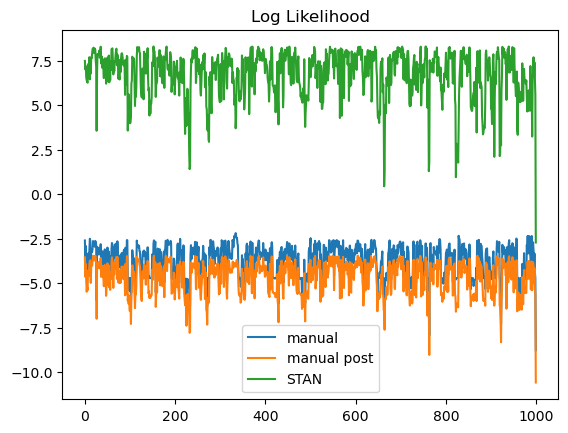

In [29]:
plt.plot(MC_log['manual lp list'])
plt.plot(MC_log["manual post list"])
plt.plot(MC_log["STAN_like_approx"])
plt.legend(["manual", "manual post", "STAN"])
plt.title("Log Likelihood")
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_log_likelihood_MCMC_draws.tex")

{'theta.1': {'mu': -4.189928771918179, 'var': 6.86408329459296},
 'theta.2': {'mu': 0.30707065430343616, 'var': 3.0430853818834294}}
{'mu': tensor([[-3.5164],
        [-0.2122]]), 'var': tensor([[12.8388,  0.0000],
        [ 0.0000,  3.5704]])}


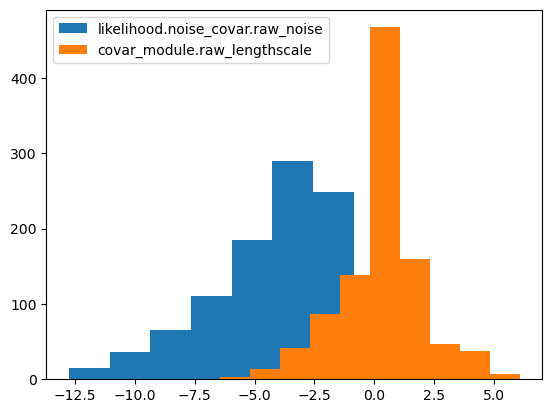

In [30]:

import pprint
pprint.pprint(MC_log["Parameter statistics"])
for param_name in MC_log['param draws dict']:
    plt.hist(MC_log['param draws dict'][param_name])
print(MC_log["Parameter prior"])
plt.legend([param[0] for param in model.named_parameters()])
plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_param_distribution.tex")

15.9
3.2
1.3
98.4


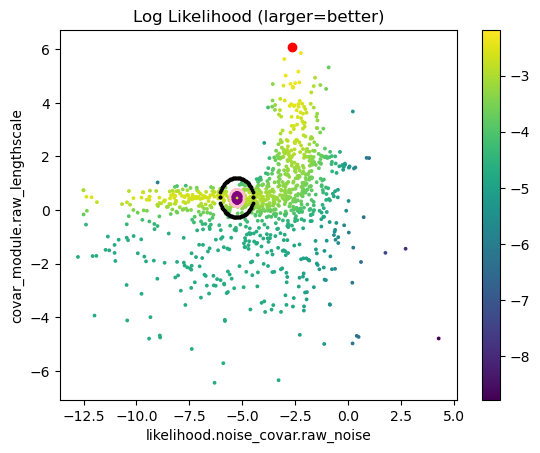

In [31]:
#
#scaling_factor = lap_log["neg MLL"]
#mu = [training_log["training_log"][param_keys[0]][-1], training_log["training_log"][param_keys[1]][-1]]
#K = lap_log["corrected Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
##plt.scatter(new_unit_x, new_unit_y, color="grey", s=3)
#K = lap_log["original symmetrized Hessian"]
#new_unit_x, new_unit_y = get_std_points(mu, K)
#plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
#

def check_if_in_interval(mu_vector, cov_matr, point, interval):
    # Create a multivariate normal distribution object
    mvn = multivariate_normal(mean=mu_vector, cov=cov_matr)
    # Calculate the probability of the datapoint
    probability = mvn.pdf(point)
    # Calculate the 2 standard deviation interval
    lower_bound = mvn.pdf(mu_vector + interval * np.sqrt(cov_matr[0][0]))
    # Check if the probability lies within the 2 standard deviation interval
    return probability >= lower_bound




def get_sub_tensor(tensor, num1, num2):
    sub_tensor = tensor[[num1, num2]][:, [num1, num2]]
    return sub_tensor


draw_prior=False
draw_uncorrected=False

what_to_draw = "manual lp list" # likelihood surface 
#what_to_draw = "manual post list" # posterior surface
#what_to_draw = "STAN_like_approx" # STAN likelihood surface

param_names = [param[0] for param in model.named_parameters()]

plot_param1 = "theta.1" 
plot_param2 = "theta.2" 
row_num = int(plot_param1[-1:]) - int(1) 
col_num = int(plot_param2[-1:]) - int(1)


filtered = False 
filtered_noise = list()
filtered_length = list()
filtered_loglike = list()

# loop to filter draws below X 
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-100):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)

if filtered:
    for i in range(len(filtered_noise)-1):
        n, l = filtered_noise[i], filtered_length[i]
        n2, l2 = filtered_noise[i+1], filtered_length[i+1]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(filtered_noise)), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(filtered_noise, filtered_length, c=filtered_loglike, s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    #print(f"{max(MC_log[what_to_draw])} : {MC_log['param draws dict']['theta.1'][max_index]} {MC_log['param draws dict']['theta.2'][max_index]}")
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")
else:
    for i in range(len(MC_log['param draws dict'][plot_param1])-1):
        n, l = MC_log['param draws dict'][plot_param1][i], MC_log['param draws dict'][plot_param2][i]
        n2, l2 = MC_log['param draws dict'][plot_param1][i+int(1)], MC_log['param draws dict'][plot_param2][i+int(1)]
        #plt.arrow(n, l, n2-n, l2-l, color=mpl.colormaps["Greens"](i/len(MC_log['param draws dict'][plot_param1])), head_length = 0.07, head_width = 0.025, length_includes_head = True)
    plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=torch.Tensor(MC_log[what_to_draw]), s=3)
    max_index = MC_log[what_to_draw].index(max(MC_log[what_to_draw]))
    plt.plot(MC_log['param draws dict'][plot_param1][max_index], MC_log['param draws dict'][plot_param2][max_index], "ro")


plt.colorbar()


mu = torch.tensor(trained_mu)[[row_num, col_num]]
K = lap_log_S["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="black", s=3)
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")


K = lap_log_AIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")

K = lap_log_BIC["corrected Hessian"]
new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
plt.scatter(new_unit_x, new_unit_y, color="purple", s=3)
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")


new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].flatten()[[row_num, col_num]], get_sub_tensor(MC_log["Parameter prior"]["var"], row_num, col_num))
if draw_prior or what_to_draw == "manual post list": 
    plt.scatter(new_unit_x, new_unit_y, color="gray", s=3)
K = lap_log_S["original symmetrized Hessian"]
print(f"{100*sum([check_if_in_interval(torch.tensor(trained_mu), K.inverse(), sample, 2) for sample in [list(sample[1]) for sample in MC_log['param draws dict'].iterrows()]]) / len(MC_log[what_to_draw])}")
try:
    new_unit_x, new_unit_y = get_std_points(mu, get_sub_tensor(K.inverse(), row_num, col_num))
    if draw_uncorrected: 
        plt.scatter(new_unit_x, new_unit_y, color="turquoise", s=3)
except: 
    pass
plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title(f"Log {'Likelihood' if 'lp' in what_to_draw else 'Posterior'} (larger=better)")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_{'likelihood' if 'lp' in what_to_draw else 'posterior'}_surface_{param_names[row_num]}-{param_names[col_num]}.tex")

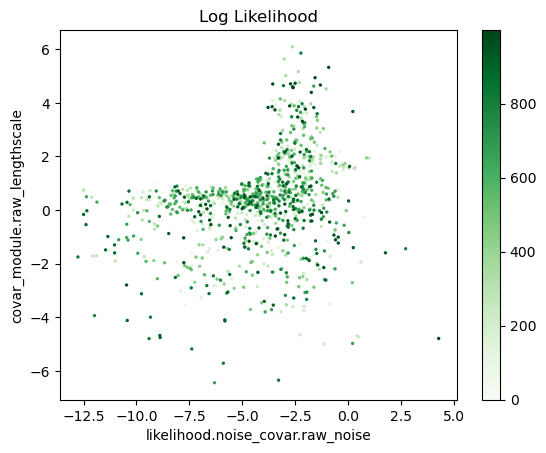

In [32]:
# Contour plot of the likelihood surface according to the explored samples
# loop to filter draws below -5000
#plot_param1 = "theta.2" 
#plot_param2 = "theta.3" 
#row_num = int(plot_param1[-1:]) - int(1) 
#col_num = int(plot_param2[-1:]) - int(1)


filtered_noise = list()
filtered_length = list()
filtered_loglike = list()
for n, l, llik in zip(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], MC_log[what_to_draw]):
    if llik > int(-5000):
        filtered_noise.append(n)
        filtered_length.append(l)
        filtered_loglike.append(llik)
plt.scatter(MC_log['param draws dict'][plot_param1], MC_log['param draws dict'][plot_param2], c=range(len(MC_log['param draws dict'][plot_param2])), cmap="Greens", s=2)
plt.colorbar() 
## Drawing the parameter Prior
#new_unit_x, new_unit_y = get_std_points(MC_log["Parameter prior"]["mu"].numpy().T[0][:2], MC_log["Parameter prior"]["var"].inverse()[:2, :2])
# Draw one standard deviation around the center of the distribution
#plt.scatter(new_unit_x, new_unit_y, color="pink", s=3)
#plt.scatter(filtered_noise, filtered_length, c=filtered_loglike)

plt.xlabel(param_names[row_num])
plt.ylabel(param_names[col_num])
plt.title("Log Likelihood")

plt.savefig(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.png")
tikzplotlib.save(f"{figure_path}/{model_name}_{dataset_name}_MCMC_likelihood_path_{param_names[row_num]}-{param_names[col_num]}.tex")

In [33]:
print(f"{model_name}")
print(f"data & LODE model & MCMC & Lap\\_0 & Lap\\_AIC & Lap\\_BIC & AIC & BIC & MLL\\\\")
print(f"{dataset_name} & {model_name} & {MCMC_approx:.2f} & {lap_approx_S:.2f} & {lap_approx_AIC:.2f} & {lap_approx_BIC:.2f} & {-AIC_approx:.2f} & {-BIC_approx:.2f} & {-loss*model.train_targets.numel():.2f}\\\\")


with open(f"{figure_path}/results.txt", 'a+') as file:
    file.write(f"{model_name}\n")
    file.write(f"data & LODE model & MCMC & Lap\\_0 & Lap\\_AIC & Lap\\_BIC & AIC & BIC & MLL\\\\\n")
    file.write(f"{dataset_name} & {model_name} & {MCMC_approx:.2f} & {lap_approx_S:.2f} & {lap_approx_AIC:.2f} & {lap_approx_BIC:.2f} & {-AIC_approx:.2f} & {-BIC_approx:.2f} & {-loss*model.train_targets.numel():.2f}\\\\")



SE
data & LODE model & MCMC & Lap\_0 & Lap\_AIC & Lap\_BIC & AIC & BIC & MLL\\
linear & SE & -3.75 & -6.76 & -8.67 & -9.89 & 17.35 & 16.56 & -6.67\\


In [34]:
dataset_name

'linear'

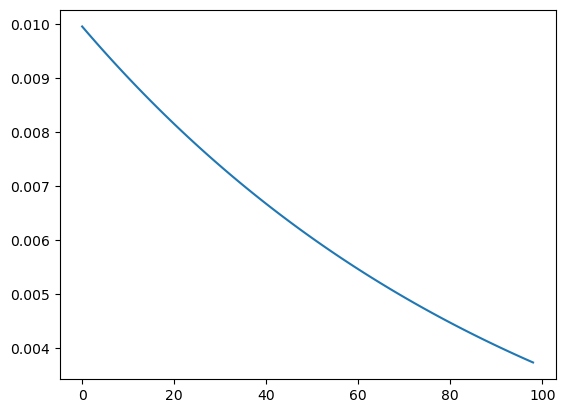

In [59]:
f = lambda i, N: np.exp(-i/N)
plt.plot([f(i-1, 100) - f(i, 100) for i in range(1, 100)])

In [83]:
train_x = torch.tensor([1, 2, 3, 4, 5])
train_y = torch.sin(train_x)
train_y

tensor([ 0.8415,  0.9093,  0.1411, -0.7568, -0.9589])

In [84]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, model_name="SE"):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if model_name == "SE":
            self.mean_module = gpytorch.means.ZeroMean()
            self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [94]:
from metrics import prior_distribution

#for (param_name, param) in model.named_parameters():
#        if params == None:
#            params = param
#        else:
#            if len(param.shape)==0:
#                params = torch.cat((params,param.unsqueeze(0)))
#            elif len(param.shape)==1:
#                params = torch.cat((params,param))
#            else:
#                params = torch.cat((params,param.squeeze(0)))

def reparameterize_model(model, theta):
    for model_param, sampled_param in zip(model.parameters(), theta):
        try:
            model_param.data = torch.full_like(model_param.data, torch.tensor(sampled_param))
        except Exception as E:
            print(E)
            print(model_param.data)
            print(torch.tensor(sampled_param))


def reparameterize_and_mll(model, likelihood, theta, train_x, train_y):
    reparameterize_model(model, theta)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    return mll(model(train_x), train_y)

def log_prior(mean, cov, params):
    prior = torch.distributions.MultivariateNormal(torch.tensor(mean), torch.tensor(cov))
    log_prob = prior.log_prob(torch.tensor(params))
    return log_prob.squeeze(0)

# Minimal example of nested sampling according to Wikipedia, probably with a lot of bugs

# Settings
LIVE_POINTS = 100
iterations = 1000

# Preparations
prior_theta_mean, prior_theta_cov = prior_distribution(model)
prior_theta_mean = [t[0] for t in prior_theta_mean.tolist()]
# hardcoding noise 1 
prior_theta_mean[0] = 1.0
prior_theta_cov[0][0] = 1e-6
live_points_list = np.random.multivariate_normal(prior_theta_mean, prior_theta_cov, LIVE_POINTS)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
model.train()
likelihood.train()
mll_theta_list = [(reparameterize_and_mll(model, likelihood, theta_i, train_x, train_y), theta_i) for theta_i in live_points_list]
# Storage and constants initialization
X_old = 1
all_prior_samples = list()
used_param_samples_history = list()
like_weights_history = list()
model_evidence_approximation = 0
neg_log_posterior_approximation = 0

# Main loop that takes care of the nested sampling
# convergence_criterion is number of iterations
for i in range(iterations):
    # get minimal marginal likelihood of current live points
    (min_mll, min_param) = mll_theta_list.pop(mll_theta_list.index(min(mll_theta_list, key=lambda x: x[0])))
    # sample new live point
    theta_i = np.random.multivariate_normal(prior_theta_mean, prior_theta_cov, 1).flatten()
    all_prior_samples.append(theta_i)
    reparameterize_model(model, theta_i)
    while not mll(model(train_x), train_y) > min_mll:
        theta_i = np.random.multivariate_normal(prior_theta_mean, prior_theta_cov, 1).flatten()
        all_prior_samples.append(theta_i)
        reparameterize_model(model, theta_i)
    # Store the accepted live point
    mll_theta_list.append((mll(model(train_x), train_y), theta_i))
    # store the removed theta_i 
    used_param_samples_history.append(min_param)
    # calculate estimated prior mass
    X_i = np.exp(-i/LIVE_POINTS)
    # calculate weight for the saved point
    w_i = X_old - X_i
    X_old = X_i
    #print(f"X_{i}: {X_i}; w_{i}: {w_i}")
    # calculate Z = Z+w_i*likelihood
    model_evidence_approximation += w_i * min_mll*len(train_x)
    neg_log_posterior_approximation += w_i * (min_mll*len(train_x) + log_prior(prior_theta_mean, prior_theta_cov, min_param))
    #print(f"Z_{i}: {model_evidence_approximation}")
    print(f"log_post at {i}: {neg_log_posterior_approximation}")
    like_weights_history.append((w_i))

print("finished iterations. Checking remaining live points")
# Loop over the remaining live points to add to the model evidence approximation
for j, (min_mll, min_param) in enumerate(mll_theta_list):
    X_k = np.exp(-(i+1+j)/LIVE_POINTS)
    w_i = X_old - X_k
    model_evidence_approximation += w_i * min_mll*len(train_x)
    neg_log_posterior_approximation += w_i * (min_mll*len(train_x) + log_prior(prior_theta_mean, prior_theta_cov, min_param))
    #print(f"Z_{i+j}: {model_evidence_approximation}")
    print(f"Z_{i+j}: {neg_log_posterior_approximation}")
    like_weights_history.append((w_i))


print(model_evidence_approximation)


TypeError: full_like(): argument 'fill_value' (position 2) must be Number, not Tensor

In [ ]:
a = [1, 2, 3, 4, 5, 6]
a.pop(a.index(1))

1